In [1]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import pandas as pd
import glob

# Constants
TARGET_SIZE = (64, 64, 32)
NUM_CLASSES = 4  # Example for one-hot encoding (e.g., tumor classes)
BATCH_SIZE = 4

In [2]:
dataframe = pd.read_csv("/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv")
df = dataframe.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID','BraTS_2019_subject_ID','BraTS_2020_subject_ID'], axis=1)
t1ce_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
t2_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
flair_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))


data = {
    't1ce': t1ce_list,
    't2': t2_list,
    'flair': flair_list,
    'label': df['Grade'].values  # Class labels for each subject
}
df = pd.DataFrame(data)


In [3]:
df.head()

,t1ce,t2,flair,label
0,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,HGG
1,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,HGG
2,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,HGG
3,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,HGG
4,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,HGG


In [17]:
def load_and_preprocess_image(t1ce_path, t2_path, flair_path):
    # Function to load images using nibabel
    print(t1ce_path)
    def load_images(t1ce_path, t2_path, flair_path):
        images = []
        for path1,path2,path3 in [t1ce_path.numpy(), t2_path.numpy(), flair_path.numpy()]:
            img1 = nib.load(path1).get_fdata()  # Load each modality
            img1 = tf.image.resize(img, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))  # Resize to 64x64x32
            img1 = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
            
            img2 = nib.load(path2).get_fdata()  # Load each modality
            img2 = tf.image.resize(img, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))  # Resize to 64x64x32
            img2 = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
            
            img3 = nib.load(path3).get_fdata()  # Load each modality
            img3 = tf.image.resize(img, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))  # Resize to 64x64x32
            img3 = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
            
            img = tf.stack(img1,img2,img3, axis=-1)  # Shape: (64, 64, 32, 3)
        
        images.append(img)
        return img

    # Use tf.py_function to call the Python function
    img = tf.py_function(load_images, (t1ce_path, t2_path, flair_path), Tout=tf.float32)
    img.set_shape((TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2], 3))  # Set output shape
    return img

In [19]:
def one_hot_encode(label):
    # Create a one-hot encoded vector
    # The mapping is: HGG -> 0 and LGG -> 1
    label_dict = {'HGG': 0, 'LGG': 1}
    
    # Convert label to integer using the dictionary
    integer_label = tf.where(tf.equal(label, 'HGG'), 0, 1)  # HGG = 0, LGG = 1
    return tf.one_hot(integer_label, NUM_CLASSES)


dataset = tf.data.Dataset.from_tensor_slices(
    (df['t1ce'].values, df['t2'].values, df['flair'].values, df['label'].values)
).map(lambda t1ce, t2, flair, label: (
        load_and_preprocess_image(t1ce, t2, flair),  # Pass tensors directly
        one_hot_encode(label)  # Directly pass symbolic tensors
    ), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(buffer_size=len(df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)


In [6]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [20]:
import tensorflow as tf
import nibabel as nib

# Assuming TARGET_SIZE is defined as (64, 64, 32)
TARGET_SIZE = (64, 64, 32)

# Function to load and preprocess the MRI image
def load_and_preprocess_image(t1ce_path, t2_path, flair_path):
    # Function to load images using nibabel
    def load_images(t1ce_path, t2_path, flair_path):
        images = []
        
        # Load each modality
        for path in [t1ce_path, t2_path, flair_path]:
            # Decode the bytes to a string
            path_str = path.numpy().decode('utf-8')  
            img = nib.load(path_str).get_fdata()  # Load each modality
            img = tf.image.resize(img, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))  # Resize to 64x64x32
            img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
            images.append(img)
        
        img = tf.stack(images, axis=-1)  # Shape: (64, 64, 32, 3)
        return img

    # Use tf.py_function to call the Python function
    img = tf.py_function(load_images, (t1ce_path, t2_path, flair_path), Tout=tf.float32)
    img.set_shape((TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2], 3))  # Set output shape
    return img

In [23]:
def one_hot_encode(label):
    # Create a one-hot encoded vector
    # The mapping is: HGG -> 0 and LGG -> 1
    label_dict = {'HGG': 0, 'LGG': 1}
    
    # Convert label to integer using the dictionary
    integer_label = tf.where(tf.equal(label, 'HGG'), 0, 1)  # HGG = 0, LGG = 1
    return tf.one_hot(integer_label, NUM_CLASSES)

# Create the TensorFlow dataset from the DataFrame
dataset = tf.data.Dataset.from_tensor_slices(
    (df['t1ce'].values, df['t2ce'].values, df['flair'].values, df['label'].values)
).map(lambda t1ce, t2, flair, label: (
        load_and_preprocess_image(t1ce, t2, flair),  # Pass tensors directly
        one_hot_encode(label)  # Directly pass symbolic tensors
    ), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(buffer_size=len(df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Inspect a single batch
for images, labels in dataset.take(1):  # Take one batch
    print("Images shape:", images.shape)  # Should output (BATCH_SIZE, 64, 64, 32, 3)
    print("Labels shape:", labels.shape)  # Should output (BATCH_SIZE, NUM_CLASSES)

KeyError: 't2ce'

In [22]:
# Example: Inspecting a single batch
for images, labels in dataset.take(1):  # Take one batch
    print("Images shape:", images.shape)  # Should output (BATCH_SIZE, 64, 64, 32, 3)
    print("Labels shape:", labels.shape)  # Should output (BATCH_SIZE, NUM_CLASSES)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: argument should be a str object or an os.PathLike object returning str, not <class 'bytes'>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_fileug7i29j9.py", line 32, in load_images
    ag__.for_stmt([ag__.ld(t1ce_path), ag__.ld(t2_path), ag__.ld(flair_path)], None, loop_body, get_state, set_state, (), {'iterate_names': 'path'})

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 449, in for_stmt
    for_fn(iter_, extra_test, body, get_state, set_state, symbol_names, opts)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 500, in _py_for_stmt
    body(target)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 466, in protected_body
    original_body(protected_iter)

  File "/tmp/__autograph_generated_fileug7i29j9.py", line 26, in loop_body
    img = ag__.converted_call(ag__.converted_call(ag__.ld(nib).load, (ag__.converted_call(ag__.ld(path).numpy, (), None, fscope_1),), None, fscope_1).get_fdata, (), None, fscope_1)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 460, in _call_unconverted
    return f(*args)

  File "/opt/conda/lib/python3.10/site-packages/nibabel/loadsave.py", line 96, in load
    filename = _stringify_path(filename)

  File "/opt/conda/lib/python3.10/site-packages/nibabel/filename_parser.py", line 41, in _stringify_path
    return pathlib.Path(filepath_or_buffer).expanduser().as_posix()

  File "/opt/conda/lib/python3.10/pathlib.py", line 960, in __new__
    self = cls._from_parts(args)

  File "/opt/conda/lib/python3.10/pathlib.py", line 594, in _from_parts
    drv, root, parts = self._parse_args(args)

  File "/opt/conda/lib/python3.10/pathlib.py", line 583, in _parse_args
    raise TypeError(

TypeError: argument should be a str object or an os.PathLike object returning str, not <class 'bytes'>


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [24]:
def load_and_preprocess_images(df):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        t1ce_path = row['t1ce']
        t2_path = row['t2']
        flair_path = row['flair']
        label = row['label']
        
        # Load each modality
        img1 = nib.load(t1ce_path).get_fdata()  # Load T1CE image
        img2 = nib.load(t2_path).get_fdata()    # Load T2 image
        img3 = nib.load(flair_path).get_fdata() # Load FLAIR image
        
        # Resize images to TARGET_SIZE
        img1 = tf.image.resize(img1, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))
        img2 = tf.image.resize(img2, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))
        img3 = tf.image.resize(img3, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))

        # Normalize images to [0, 1]
        img1 = tf.cast(img1, tf.float32) / 255.0
        img2 = tf.cast(img2, tf.float32) / 255.0
        img3 = tf.cast(img3, tf.float32) / 255.0
        
        # Stack modalities into one image
        img = tf.stack([img1, img2, img3], axis=-1)  # Shape: (64, 64, 32, 3)

        images.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)  # Shape: (num_samples, 64, 64, 32, 3)
    labels = np.array(labels)   # Shape: (num_samples,)

    return images, labels

# Load and preprocess the data
images, labels = load_and_preprocess_images(df)

# One-hot encode labels
def one_hot_encode(labels):
    label_dict = {'HGG': 0, 'LGG': 1}
    integer_labels = [label_dict[label] for label in labels]
    return tf.one_hot(integer_labels, NUM_CLASSES)

one_hot_labels = one_hot_encode(labels)  # Shape: (num_samples, NUM_CLASSES)

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, one_hot_labels))
dataset = dataset.shuffle(buffer_size=len(df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Example: Inspecting a single batch
for batch_images, batch_labels in dataset.take(1):
    print("Images shape:", batch_images.shape)  # Should output (BATCH_SIZE, 64, 64, 32, 3)
    print("Labels shape:", batch_labels.shape) 

ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width

In [1]:
import tensorflow as tf
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

In [35]:
# Constants
TARGET_SIZE = (64, 64, 32)  # Width, Height, Depth
BATCH_SIZE = 32
NUM_CLASSES = 2  # HGG and LGG

def resize_image(img, target_shape):
    """
    Resize a 3D image to the target shape using scipy's zoom with bicubic interpolation.
    Assumes img is a 3D numpy array and target_shape is a tuple (new_width, new_height, new_depth).
    """
    # Calculate zoom factors for resizing
    zoom_factors = [
        target_shape[i] / img.shape[i] for i in range(len(target_shape))
    ]
    # Use bicubic interpolation
    resized_img = zoom(img, zoom_factors, order=3)  # Order 3 for bicubic interpolation
    return resized_img

def load_and_preprocess_image(t1ce_path, t2_path, flair_path):
    # Load images using nibabel
    img1 = nib.load(t1ce_path).get_fdata()  # Load T1CE image
    img2 = nib.load(t2_path).get_fdata()    # Load T2 image
    img3 = nib.load(flair_path).get_fdata() # Load FLAIR image

    # Resize images to (64, 64, 32)
    img1_resized = resize_image(img1, TARGET_SIZE)
    img2_resized = resize_image(img2, TARGET_SIZE)
    img3_resized = resize_image(img3, TARGET_SIZE)

    # Normalize images to [0, 1]
    img1_resized /= 255.0
    img2_resized /= 255.0
    img3_resized /= 255.0

    # Stack modalities to create a 4D image of shape (64, 64, 32, 3)
    img = np.stack([img1_resized, img2_resized, img3_resized], axis=-1)  # Shape: (64, 64, 32, 3)

    return img

def one_hot_encode(label):
    # Create a one-hot encoded vector
    label_dict = {'HGG': 0, 'LGG': 1}
    integer_label = label_dict[label]  # Convert label to integer
    return tf.one_hot(integer_label, NUM_CLASSES)

def create_dataset(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        t1ce_path = row['t1ce']
        t2_path = row['t2']
        flair_path = row['flair']
        label = row['label']

        # Load and preprocess each image
        img = load_and_preprocess_image(t1ce_path, t2_path, flair_path)
        images.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)  # Shape: (num_samples, 64, 64, 32, 3)
    labels = np.array(labels)   # Shape: (num_samples,)

    # One-hot encode labels
    one_hot_labels = np.array([one_hot_encode(label) for label in labels])

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, one_hot_labels))
    dataset = dataset.shuffle(buffer_size=len(df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

dataset = create_dataset(df)

for batch_images, batch_labels in dataset.take(1):
    print("Batch size (number of samples):", batch_images.shape[0])  # Number of samples in this batch
    print("Image shape:", batch_images.shape)  # Should output (BATCH_SIZE, 64, 64, 32, 3)
    print("Label shape:", batch_labels.shape)   # Should output (BATCH_SIZE, 2)

Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)


In [36]:
import gc
gc.collect()
print("success")

success


In [37]:
for batch_images, batch_labels in dataset:
    print("Batch size (number of samples):", batch_images.shape[0])  # Number of samples in this batch
    print("Image shape:", batch_images.shape)  # (BATCH_SIZE, 64, 64, 3)
    print("Label shape:", batch_labels.shape)   # (BATCH_SIZE, 2)

Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of

In [40]:
tf.data.experimental.save(dataset,'/kaggle/working/processed_dataset/')

In [2]:
def load_dataset(path):
    return tf.data.experimental.load(path)


loaded_dataset = load_dataset('/kaggle/input/processed-brats20-tensorfile/processed_dataset')

In [3]:
len(loaded_dataset)

12

In [4]:
(11*32)+17

369

In [8]:
for batch_images, batch_labels in loaded_dataset:
    print("Batch size (number of samples):", batch_images.shape[0])  # Number of samples in this batch
    print("Image shape:", batch_images.shape)  # (BATCH_SIZE, 64, 64, 3)
    print("Label shape:", batch_labels.shape)   # (BATCH_SIZE, 2)

Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of samples): 32
Image shape: (32, 64, 64, 32, 3)
Label shape: (32, 2)
Batch size (number of

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `data` is a list of batches where each batch is a tuple: (images, labels)
# Example: data = [(images_batch_1, labels_batch_1), (images_batch_2, labels_batch_2), ...]
data=loaded_dataset
# Concatenate all batches into one tensor
all_images = tf.concat([batch[0] for batch in data], axis=0)  # Shape: (total_samples, 64, 64, 32, 3)
all_labels = tf.concat([batch[1] for batch in data], axis=0)  # Shape: (total_samples, 2)

# Convert tensors to NumPy arrays for sklearn compatibility
all_images_np = all_images.numpy()
all_labels_np = all_labels.numpy()

# Split into training+validation and test set
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    all_images_np, all_labels_np, test_size=0.2, random_state=42
)

# Further split training+validation into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of the full dataset
)

# Convert back to TensorFlow tensors if needed
train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)
val_images = tf.convert_to_tensor(val_images)
val_labels = tf.convert_to_tensor(val_labels)
test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

# Print the shapes to verify
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (221, 64, 64, 32, 3)
Train labels shape: (221, 2)
Validation images shape: (74, 64, 64, 32, 3)
Validation labels shape: (74, 2)
Test images shape: (74, 64, 64, 32, 3)
Test labels shape: (74, 2)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Define a multi-head self-attention block
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.attention(x, x)  # Self-attention
        return attn_output

# Define a transformer model to process each 2D slice
class SliceTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim):
        super(SliceTransformer, self).__init__()
        self.patch_embedding = layers.Dense(embedding_dim)  # Patch embedding layer
        self.attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(embedding_dim * 2, activation='relu'),  # Feed-forward network
            layers.Dense(embedding_dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        # Split each slice into patches and embed them
        patches = self.split_into_patches(x, patch_size=16)  # Custom patch splitting function
        embedded_patches = self.patch_embedding(patches)

        # Apply self-attention
        attn_output = self.attention(embedded_patches)
        out1 = self.norm1(attn_output + embedded_patches)  # Skip connection
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        return self.norm2(ffn_output + out1)  # Skip connection

    def split_into_patches(self, x, patch_size):
        batch_size = tf.shape(x)[0]  # Get batch size
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = tf.shape(x)[3]
        
        # Extract patches
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape to (batch_size, num_patches, patch_size * patch_size * channels)
        return tf.reshape(patches, (batch_size, -1, patch_size * patch_size * channels))

# Main model that processes the entire volume
class VolumeTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim, num_classes):
        super(VolumeTransformer, self).__init__()
        self.slice_transformer = SliceTransformer(num_heads, key_dim, embedding_dim)
        self.inter_slice_attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.global_pooling = layers.GlobalAveragePooling3D()  # Global pooling layer
        self.dense = layers.Dense(num_classes, activation='softmax')  # Output layer

    def call(self, volume):
        # volume shape: [batch_size, height, width, depth, channels]
        batch_size = tf.shape(volume)[0]  # Get batch size
        depth = tf.shape(volume)[3]  # Depth (number of slices)

        # Use tf.map_fn to apply the transformer over the depth slices
        slice_outputs = tf.map_fn(lambda i: self.slice_transformer(volume[:, :, :, i, :]), 
                                   tf.range(depth), 
                                   dtype=tf.float32)  # Collect outputs for each slice

        # Stack the features and apply inter-slice attention
        inter_slice_output = self.inter_slice_attention(slice_outputs)  # Apply inter-slice attention

        # Now inter_slice_output has shape (batch_size, depth, features)
        # Reshape for GlobalAveragePooling3D
        # Create a new axis for the 'channels' dimension to match the expected input
        inter_slice_output = tf.expand_dims(inter_slice_output, axis=-1)  # (batch_size, depth, features, 1)

        # Apply global average pooling
        pooled_output = self.global_pooling(inter_slice_output)  # Now it can accept the shape
        
        # Pass to the dense layer
        return self.dense(pooled_output)


# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Create a batch size directly during model training
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Initialize and compile the model
num_classes = 2  # Adjust according to your number of classes
model = VolumeTransformer(num_heads=8, key_dim=64, embedding_dim=512, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate the model
model.evaluate(test_dataset)

Epoch 1/10
6/7 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.5934 - loss: 0.6429 

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_30/4242613778.py", line 109, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1576, in categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1482, in categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 564, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,2] labels_size=[29,2]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_one_step_on_iterator_16364]

In [29]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Set a smaller batch size to avoid dropping too many rows
BATCH_SIZE = 16  # Adjusted batch size

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

for x, y in val_dataset:
    print("Shape of x:", x.shape)  # Check input shape
    print("Shape of y:", y.shape)  # Check label shape

Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)


In [30]:
for x, y in train_dataset:
    print("Shape of x:", x.shape)  # Check input shape
    print("Shape of y:", y.shape)  # Check label shape

Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)
Shape of x: (16, 64, 64, 32, 3)
Shape of y: (16, 2)


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, from_logits=False, name='focal_loss'):
        super(FocalLoss, self).__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred)  # Convert logits to probabilities
        y_true = tf.cast(y_true, tf.float32)

        # Calculate focal loss
        p_t = tf.reduce_sum(y_true * y_pred, axis=1)  # Probabilities of true class
        loss = -self.alpha * tf.pow(1 - p_t, self.gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
        return tf.reduce_mean(loss)

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        self.tp.assign_add(tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)))
        self.tn.assign_add(tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32)))
        self.fp.assign_add(tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32)))
        self.fn.assign_add(tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32)))

    def result(self):
        sensitivity = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        return (sensitivity + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


# Define a multi-head self-attention block
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.attention(x, x)  # Self-attention
        return attn_output

# Define a transformer model to process each 2D slice
class SliceTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim):
        super(SliceTransformer, self).__init__()
        self.patch_embedding = layers.Dense(embedding_dim)  # Patch embedding layer
        self.attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-8)
        self.ffn = tf.keras.Sequential([
            layers.Dense(embedding_dim * 2, activation='relu'),  # Feed-forward network
            layers.Dense(embedding_dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-8)

    def call(self, x):
        # Split each slice into patches and embed them
        patches = self.split_into_patches(x, patch_size=16)  # Custom patch splitting function
        embedded_patches = self.patch_embedding(patches)

        # Apply self-attention
        attn_output = self.attention(embedded_patches)
        out1 = self.norm1(attn_output + embedded_patches)  # Skip connection
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        return self.norm2(ffn_output + out1)  # Skip connection

    def split_into_patches(self, x, patch_size):
        batch_size = tf.shape(x)[0]  # Get batch size
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = tf.shape(x)[3]
        
        # Extract patches
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape to (batch_size, num_patches, patch_size * patch_size * channels)
        return tf.reshape(patches, (batch_size, -1, patch_size * patch_size * channels))

# Main model that processes the entire volume
class VolumeTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim, num_classes):
        super(VolumeTransformer, self).__init__()
        self.slice_transformer = SliceTransformer(num_heads, key_dim, embedding_dim)
        self.inter_slice_attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.global_pooling = layers.GlobalAveragePooling3D()  # Global pooling layer
        self.dense = layers.Dense(num_classes, activation='sigmoid')  # Output layer

    def call(self, volume):
        # volume shape: [batch_size, height, width, depth, channels]
        batch_size = tf.shape(volume)[0]  # Get batch size
        depth = tf.shape(volume)[3]  # Depth (number of slices)
        slice_outputs = tf.map_fn(lambda i: self.slice_transformer(volume[:, :, :, i, :]), 
                                   tf.range(depth), 
                                   dtype=tf.float32)  # Collect outputs for each slice

        slice_outputs = tf.transpose(slice_outputs, perm=[1, 0, 2, 3])  # (batch_size, depth, features)
        inter_slice_output = self.inter_slice_attention(slice_outputs)  # Apply inter-slice attention
        inter_slice_output = tf.expand_dims(inter_slice_output, axis=-1)  # (batch_size, depth, features, 1)
        pooled_output = self.global_pooling(inter_slice_output)  # Now it can accept the shape
        output = self.dense(pooled_output)

        return output

# Initialize and compile the model
num_classes = 2  # Adjust according to your number of classes
model = VolumeTransformer(num_heads=8, key_dim=64, embedding_dim=1024, num_classes=num_classes)
model.compile(optimizer='adamw', loss=FocalLoss(alpha=0.8, gamma=3.0), metrics=[BalancedAccuracy()])
# Set up EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=50,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with EarlyStopping
model.fit(train_dataset, validation_data=val_dataset, epochs=500, callbacks=[early_stopping])
                               
# Evaluate the model
model.evaluate(test_dataset)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 181s 13s/step - balanced_accuracy: 0.4931 - loss: 0.0268 - val_balanced_accuracy: 0.5000 - val_loss: 3.2286e-15
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 170s 13s/step - balanced_accuracy: 0.5000 - loss: 7.8700e-16 - val_balanced_accuracy: 0.5000 - val_loss: 1.4279e-22
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 169s 13s/step - balanced_accuracy: 0.5000 - loss: 5.1980e-23 - val_balanced_accuracy: 0.5000 - val_loss: 4.3679e-25
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 170s 13s/step - balanced_accuracy: 0.5000 - loss: 2.7205e-25 - val_balanced_accuracy: 0.5000 - val_loss: 6.9264e-26
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 13s/step - balanced_accuracy: 0.5000 - loss: 6.1896e-26 - val_balanced_accuracy: 0.5000 - val_loss: 4.9567e-26
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 169s 13s/step - balanced_accuracy: 0.5000 - loss: 4.5570e-26 - val_balanced_accuracy: 0.5000 - val_loss: 3.5442e-26
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 170s 13s/step - balanced_accuracy: 

[2.998934849883363e-26, 0.5]

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from sklearn.metrics import f1_score

# Define the custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')  # True positives
        self.fp = self.add_weight(name='fp', initializer='zeros')  # False positives
        self.fn = self.add_weight(name='fn', initializer='zeros')  # False negatives

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convert predictions to class labels
        y_true = tf.argmax(y_true, axis=-1)

        # Calculate true positives, false positives, and false negatives
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

# The rest of your model code remains unchanged
# Define a multi-head self-attention block
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.attention(x, x)  # Self-attention
        return attn_output

# Define a transformer model to process each 2D slice
class SliceTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim):
        super(SliceTransformer, self).__init__()
        self.patch_embedding = layers.Dense(embedding_dim)  # Patch embedding layer
        self.attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(embedding_dim * 2, activation='relu'),  # Feed-forward network
            layers.Dense(embedding_dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        patches = self.split_into_patches(x, patch_size=16)
        embedded_patches = self.patch_embedding(patches)

        attn_output = self.attention(embedded_patches)
        out1 = self.norm1(attn_output + embedded_patches)
        ffn_output = self.ffn(out1)
        return self.norm2(ffn_output + out1)

    def split_into_patches(self, x, patch_size):
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = tf.shape(x)[3]
        
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return tf.reshape(patches, (batch_size, -1, patch_size * patch_size * channels))

# Main model that processes the entire volume
class VolumeTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim, num_classes):
        super(VolumeTransformer, self).__init__()
        self.slice_transformer = SliceTransformer(num_heads, key_dim, embedding_dim)
        self.inter_slice_attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.global_pooling = layers.GlobalAveragePooling3D()
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, volume):
        batch_size = tf.shape(volume)[0]
        depth = tf.shape(volume)[3]

        slice_outputs = tf.map_fn(lambda i: self.slice_transformer(volume[:, :, :, i, :]), 
                                   tf.range(depth), 
                                   dtype=tf.float32)

        inter_slice_output = self.inter_slice_attention(slice_outputs)
        inter_slice_output = tf.expand_dims(inter_slice_output, axis=-1)
        pooled_output = self.global_pooling(inter_slice_output)
        
        return self.dense(pooled_output)


# Initialize and compile the model
num_classes = 2  # Adjust according to your number of classes
model = VolumeTransformer(num_heads=8, key_dim=64, embedding_dim=512, num_classes=num_classes)

# Compile the model with the F1 score metric
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=[F1Score()])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with EarlyStopping
model.fit(train_dataset, validation_data=val_dataset, epochs=500, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(test_dataset)

Epoch 1/500


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(16, 2), output.shape=(32, 2)

In [9]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        
        self.wq = tf.keras.layers.Dense(key_dim)
        self.wk = tf.keras.layers.Dense(key_dim)
        self.wv = tf.keras.layers.Dense(key_dim)
        
        self.dense = tf.keras.layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        q = self.wq(inputs)  # Query
        k = self.wk(inputs)  # Key
        v = self.wv(inputs)  # Value
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True) 
        scaled_attention_logits /= tf.sqrt(tf.cast(self.depth, tf.float32))
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)
        output = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))
        
        return self.dense(output)

In [10]:
class VisionTransformer2D(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformer2D, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Reshape the input for the attention mechanism
        batch_size = tf.shape(x)[0]
        num_slices = x.shape[2]  # 32 slices
        x = tf.reshape(x, (batch_size * num_slices, TARGET_SIZE[0], TARGET_SIZE[1], 3))  # Reshape to (batch_size * 32, 64, 64, 3)
        
        # Flatten to (batch_size * num_slices, 64 * 64, 3) for the attention mechanism
        x = tf.reshape(x, (batch_size * num_slices, -1, 3))

        # Apply the multi-head self-attention
        x = self.attention(x)

        # Flatten for classification
        x = self.flatten(x)

        # Pass through dense layers
        x = self.dense(x)
        x = self.classifier(x)

        return x

# Compile and train the model
def train_architecture_1(dataset):
    model = VisionTransformer2D(num_classes=NUM_CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(dataset, epochs=10)

In [11]:
class VisionTransformer3D(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformer3D, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.conv1 = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Apply 3D convolution
        x = self.conv1(x)

        # Reshape to (batch_size, depth, height, width, channels) for attention
        x = tf.reshape(x, (tf.shape(x)[0], -1, 64 * 64, 32))  # (batch_size, new_depth, height * width, channels)

        # Apply attention
        x = self.attention(x)

        # Flatten for classification
        x = self.flatten(x)
        x = self.dense(x)
        x = self.classifier(x)

        return x

# Compile and train the model
def train_architecture_2(dataset):
    model = VisionTransformer3D(num_classes=NUM_CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(dataset, epochs=10)

In [13]:
class VisionTransformerSingleModality(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformerSingleModality, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Flatten the input for attention
        x = self.flatten(x)

        # Apply multi-head self-attention
        x = self.attention(x)

        # Classification
        x = self.dense(x)
        return x

class VisionTransformerFused(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformerFused, self).__init__()
        self.vit1 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.vit2 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.vit3 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.fusion_dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Split the input into three modalities
        x1, x2, x3 = tf.split(x, num_or_size_splits=3, axis=-1)

        # Process each modality with a separate ViT
        output1 = self.vit1(x1)
        output2 = self.vit2(x2)
        output3 = self.vit3(x3)

        # Concatenate the outputs and pass through the fusion layer
        fused = tf.concat([output1, output2, output3], axis=1)
        fused = self.fusion_dense(fused)
        return self.classifier(fused)

# Compile and train the model
def train_architecture_3(dataset):
    model = VisionTransformerFused(num_classes=NUM_CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(dataset, epochs=10)

In [15]:
dataset= loaded_dataset
print("Training Architecture 1")
model1 = train_architecture_1(dataset)

# Architecture 2
print("Training Architecture 2")
model2 = train_architecture_2(dataset)

# Architecture 3
print("Training Architecture 3")
model3 = train_architecture_3(dataset)

Training Architecture 1
Epoch 1/10


ValueError: Exception encountered when calling VisionTransformer2D.call().

[1mShapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 512) for variable path='vision_transformer2d/dense_4/kernel'[0m

Arguments received by VisionTransformer2D.call():
  • x=tf.Tensor(shape=(None, 64, 64, 32, 3), dtype=float32)

In [ ]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import pandas as pd

# Constants
TARGET_SIZE = (64, 64, 32)
NUM_CLASSES = 2  # HGG, LGG
BATCH_SIZE = 4

# Sample DataFrame for paths and labels
data = {
    't1ce': ['path/to/t1ce_subject1.nii.gz', 'path/to/t1ce_subject2.nii.gz'],  # Add actual paths
    't2': ['path/to/t2_subject1.nii.gz', 'path/to/t2_subject2.nii.gz'],  # Add actual paths
    'flair': ['path/to/flair_subject1.nii.gz', 'path/to/flair_subject2.nii.gz'],  # Add actual paths
    'label': ['HGG', 'LGG']  # Class labels for each subject
}
df = pd.DataFrame(data)

# Function to load and preprocess the MRI image
def load_and_preprocess_image(image_paths, label):
    # Load the 3D MRI scans using nibabel
    images = []
    for path in image_paths:
        img = nib.load(path.decode("utf-8")).get_fdata()  # Load each modality
        img = tf.image.resize(img, (TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2]))  # Resize to 64x64x32
        img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
        images.append(img)

    # Stack modalities along the last axis
    img = tf.stack(images, axis=-1)  # Shape: (64, 64, 32, 3)
    return img, label

# Function to perform one-hot encoding on labels
def one_hot_encode(label):
    label_dict = {'HGG': 0, 'LGG': 1}
    return tf.one_hot(label_dict[label.decode("utf-8")], NUM_CLASSES)

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        
        self.wq = tf.keras.layers.Dense(key_dim)
        self.wk = tf.keras.layers.Dense(key_dim)
        self.wv = tf.keras.layers.Dense(key_dim)
        
        self.dense = tf.keras.layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        q = self.wq(inputs)  # Query
        k = self.wk(inputs)  # Key
        v = self.wv(inputs)  # Value
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True) 
        scaled_attention_logits /= tf.sqrt(tf.cast(self.depth, tf.float32))
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)
        output = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))
        
        return self.dense(output)

# Architecture 1: Vision Transformer for 2D Flattening
class VisionTransformer2D(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformer2D, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # x: (batch_size, 64, 64, 32, 3)
        batch_size = tf.shape(x)[0]
        
        # Reshape to (batch_size * 32, 64, 64, 3)
        x = tf.reshape(x, (batch_size * TARGET_SIZE[2], TARGET_SIZE[0], TARGET_SIZE[1], 3))  

        # Flatten to (batch_size * 32, 64 * 64, 3)
        x = tf.reshape(x, (batch_size * TARGET_SIZE[2], -1, 3))

        # Apply attention
        x = self.attention(x)

        # Flatten for classification
        x = self.flatten(x)
        x = self.dense(x)
        return self.classifier(x)

# Architecture 2: Vision Transformer without Flattening
class VisionTransformer3D(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformer3D, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Shape x: (batch_size, 64, 64, 32, 3)
        batch_size = tf.shape(x)[0]
        
        # Reshape to (batch_size, depth, height * width, channels)
        x = tf.reshape(x, (batch_size, TARGET_SIZE[2], TARGET_SIZE[0] * TARGET_SIZE[1], 3))

        # Apply attention directly to the 3D volume
        x = self.attention(x)

        # Flatten for classification
        x = self.flatten(x)
        x = self.dense(x)
        return self.classifier(x)

# Architecture 3: Three ViTs with Fusion
class VisionTransformerSingleModality(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformerSingleModality, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Flatten the input for attention
        x = self.flatten(x)

        # Apply multi-head self-attention
        x = self.attention(x)

        # Classification
        x = self.dense(x)
        return x

class VisionTransformerFused(tf.keras.Model):
    def __init__(self, num_classes, num_heads=4, key_dim=64):
        super(VisionTransformerFused, self).__init__()
        self.vit1 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.vit2 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.vit3 = VisionTransformerSingleModality(num_classes, num_heads=num_heads, key_dim=key_dim)
        self.fusion_dense = tf.keras.layers.Dense(512, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Split the input into three modalities
        x1, x2, x3 = tf.split(x, num_or_size_splits=3, axis=-1)

        # Process each modality with a separate ViT
        output1 = self.vit1(x1)
        output2 = self.vit2(x2)
        output3 = self.vit3(x3)

        # Concatenate the outputs and pass through the fusion layer
        fused = tf.concat([output1, output2, output3], axis=1)
        fused = self.fusion_dense(fused)
        return self.classifier(fused)

# Create TensorFlow Dataset
def preprocess_data(t1ce, t2, flair, label):
    images, label = tf.py_function(load_and_preprocess_image, [[t1ce, t2, flair], label], [tf.float32, tf.string])
    images.set_shape((TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2], 3))  # Ensure correct shape
    label = one_hot_encode(label)  # One-hot encode labels
    return images, label

# Create the dataset
dataset = (
    tf.data.Dataset.from_tensor_slices((df['t1ce'].values, df['t2'].values, df['flair'].values, df['label'].values))
    .map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=len(df))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Train the models
def train_model(model, dataset):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(dataset, epochs=10)

# Train each architecture
# Architecture 1
print("Training Architecture 1")
model1 = VisionTransformer2D(num_classes=NUM_CLASSES)
train_model(model1, dataset)

# Architecture 2
print("Training Architecture 2")
model2 = VisionTransformer3D(num_classes=NUM_CLASSES)
train_model(model2, dataset)

# Architecture 3
print("Training Architecture 3")
model3 = VisionTransformerFused(num_classes=NUM_CLASSES)
train_model(model3, dataset)


# PC4

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

filepaths = []
labels = []

folds = os.listdir(train_dir)

for fold in folds:
    foldpath =os.path.join(train_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
train_df = pd.DataFrame(data = {'Filepaths':filepaths,'Labels':labels})
train_df

,Filepaths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical


df = train_df

df['Labels'] = df['Labels'].astype(str)
df = pd.concat([df['Filepaths'], pd.get_dummies(df['Labels'])], axis=1)

# Step 2: Set parameters
image_size = (224, 224)  # Define your target image size

# Step 3: Convert DataFrame columns to lists
image_paths = df['Filepaths'].tolist()
labels = df.drop(columns=['Filepaths']).values  # Convert one-hot columns to numpy array

# Step 4: Create a tf.data.Dataset
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Step 5: Use from_tensor_slices to create a dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(lambda path, label: load_image(path, label), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(16).prefetch(tf.data.AUTOTUNE)  # Adjust batch size as needed


In [4]:
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

filepaths = []
labels = []

folds = os.listdir(test_dir)

for fold in folds:
    foldpath =os.path.join(test_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
ts_df = pd.DataFrame(data = {'Filepaths':filepaths,'Labels':labels})
ts_df

,Filepaths,Labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assuming ts_df is your DataFrame
df = ts_df

# Convert labels to strings and create one-hot encoded columns
df['Labels'] = df['Labels'].astype(str)
df = pd.concat([df['Filepaths'], pd.get_dummies(df['Labels'])], axis=1)

# Step 2: Set parameters
image_size = (224, 224)  # Define your target image size

# Step 3: Convert DataFrame columns to lists
image_paths = df['Filepaths'].tolist()
labels = df.drop(columns=['Filepaths']).values  # Convert one-hot columns to numpy array

# Step 4: Create a function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Changed to channels=3 for RGB images
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Step 5: Create a tf.data.Dataset from the image paths and labels
ts_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Map the load_image function to the dataset
ts_dataset = ts_dataset.map(lambda path, label: load_image(path, label), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the dataset
ts_dataset = ts_dataset.batch(16).prefetch(tf.data.AUTOTUNE)  # Adjust batch size as needed

# Now you can use ts_dataset for training your mode

In [23]:
df

,Filepaths,glioma,meningioma,notumor,pituitary
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,False,False,False,True
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,False,False,False,True
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,False,False,False,True
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,False,False,False,True
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,False,False,False,True
...,...,...,...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,True,False,False,False
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,True,False,False,False
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,True,False,False,False
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,True,False,False,False


In [12]:
for x, y in dataset:
    print("Shape of x:", x.shape)  # Check input shape
    print("Shape of y:", y.shape)  # Check label shape

Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)
Shape of x: (16, 224, 224, 1)
Shape of y: (16, 4)


In [14]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `dataset` is your original TensorFlow dataset
# Step 1: Extract images and labels into NumPy arrays
images = []
labels = []

for x, y in dataset:
    images.append(x.numpy())  # Convert each batch of images to NumPy
    labels.append(y.numpy())  # Convert each batch of labels to NumPy

# Concatenate the lists into NumPy arrays
images_np = np.concatenate(images, axis=0)  # Shape: (total_samples, 224, 224, 1)
labels_np = np.concatenate(labels, axis=0)  # Shape: (total_samples, 4)

# Step 2: Perform train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    images_np, labels_np, test_size=0.2, random_state=42
)

# Step 3: Convert back to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Optionally, you can shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(16, drop_remainder=True)
test_dataset = test_dataset.batch(16, drop_remainder=True)

# You can check the shapes of the first batch in the new datasets
for x, y in train_dataset:
    print("Train Shape of x:", x.shape)  # Should print (batch_size, 224, 224, 1)
    print("Train Shape of y:", y.shape)  # Should print (batch_size, 4)

for x, y in test_dataset:
    print("Test Shape of x:", x.shape)  # Should print (batch_size, 224, 224, 1)
    print("Test Shape of y:", y.shape)  # Should print (batch_size, 4)


Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Shape of x: (16, 224, 224, 1)
Train Shape of y: (16, 4)
Train Sh

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Allocate memory growth for the GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.attention(x, x)  # Self-attention
        return attn_output

# Image Transformer Model with Positional Embeddings
class ImageTransformer(Model):
    def __init__(self, num_heads, key_dim, embedding_dim, num_classes):
        super(ImageTransformer, self).__init__()
        self.patch_embedding = layers.Dense(embedding_dim)  # Patch embedding layer
        self.attention = MultiHeadSelfAttention(num_heads, key_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-8)
        self.ffn = tf.keras.Sequential([
            layers.Dense(embedding_dim * 2, activation='relu'),  # Feed-forward network
            layers.Dense(embedding_dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-8)
        self.global_pooling = layers.GlobalAveragePooling1D()  # Global pooling layer for 1D input
        self.dense = layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification

        # Positional embedding
        self.positional_embedding = layers.Embedding(input_dim=196, output_dim=embedding_dim)  # Assuming 196 patches

    def call(self, x):
        # Split into patches
        batch_size = tf.shape(x)[0]  # Get batch size
        height = tf.shape(x)[1]  # Height of the image
        width = tf.shape(x)[2]  # Width of the image

        # Extract patches
        patch_size = 16  # Size of each patch
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape to (batch_size, num_patches, patch_size * patch_size)
        patches = tf.reshape(patches, (batch_size, -1, patch_size * patch_size))

        embedded_patches = self.patch_embedding(patches)  # Shape: (batch_size, num_patches, embedding_dim)

        # Add positional embeddings
        num_patches = tf.shape(embedded_patches)[1]  # Get the number of patches
        positions = tf.range(start=0, limit=num_patches, delta=1)  # Shape: (num_patches,)
        positional_embeddings = self.positional_embedding(positions)  # Shape: (num_patches, embedding_dim)
        
        embedded_patches += positional_embeddings  # Adding positional embeddings
        
        attn_output = self.attention(embedded_patches)
        out1 = self.norm1(attn_output + embedded_patches)  # Skip connection
        
        ffn_output = self.ffn(out1)
        ffn_output = self.norm2(ffn_output + out1)  # Skip connection

        pooled_output = self.global_pooling(ffn_output)
        return self.dense(pooled_output)  # Outputs shape should be (batch_size, num_classes)

# Initialize and compile the model
num_classes = 4  # Set this to your number of classes
model = ImageTransformer(num_heads=8, key_dim=64, embedding_dim=1024, num_classes=num_classes)
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set up EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

# # Train the model with EarlyStopping and ReduceLROnPlateau
# model.fit(dataset, validation_data=ts_dataset, epochs=500, callbacks=[early_stopping, reduce_lr])

Physical devices cannot be modified after being initialized


In [30]:
model.summary()

Model: "image_transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ ?                      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_self_attention_1     │ ?                      │     2,099,712 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ ?                      │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │     4,197,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ ?                      │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │       200,704 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,307,470 (77.47 MB)

 Trainable params: 6,769,156 (25.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,538,314 (51.64 MB)

In [27]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=500, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
  3/285 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.1806 - loss: 10.1603

I0000 00:00:1730166992.331099     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 12 bytes spill stores, 12 bytes spill loads



285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.3767 - loss: 2.8320 - val_accuracy: 0.6303 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 2/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6473 - loss: 0.8948 - val_accuracy: 0.7254 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 3/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7653 - loss: 0.6536 - val_accuracy: 0.8028 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 4/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8086 - loss: 0.5507 - val_accuracy: 0.7799 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 5/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8012 - loss: 0.5814 - val_accuracy: 0.7958 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 6/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8093 - loss: 0.5352 - val_accuracy: 0.7817 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 7/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8231 - loss: 

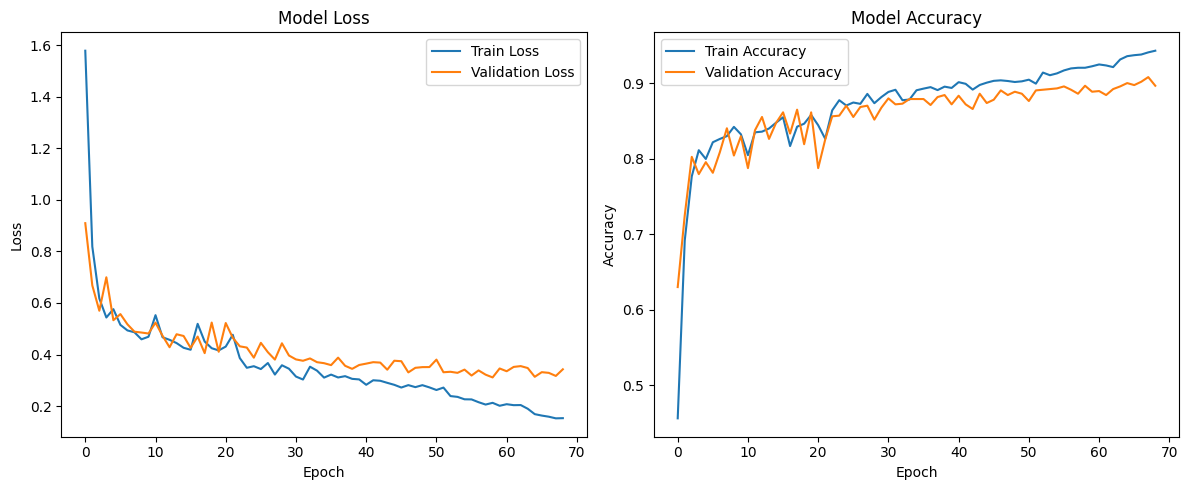

In [28]:
import matplotlib.pyplot as plt
# Visualization of training history
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history)

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the best training and validation loss
best_train_loss = min(train_loss)
best_val_loss = min(val_loss)

# Get the best training and validation accuracy
best_train_accuracy = max(train_accuracy)
best_val_accuracy = max(val_accuracy)

In [32]:
# Get the epochs corresponding to the best values
best_train_loss_epoch = train_loss.index(best_train_loss) + 1  # +1 to adjust for 0-indexing
best_val_loss_epoch = val_loss.index(best_val_loss) + 1
best_train_accuracy_epoch = train_accuracy.index(best_train_accuracy) + 1
best_val_accuracy_epoch = val_accuracy.index(best_val_accuracy) + 1

# Print the best values
print(f"Best Training Loss: {best_train_loss:.4f} at Epoch: {best_train_loss_epoch}")
print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch: {best_val_loss_epoch}")
print(f"Best Training Accuracy: {best_train_accuracy:.4f} at Epoch: {best_train_accuracy_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch: {best_val_accuracy_epoch}")

Best Training Loss: 0.1527 at Epoch: 68
Best Validation Loss: 0.3114 at Epoch: 59
Best Training Accuracy: 0.9434 at Epoch: 69
Best Validation Accuracy: 0.9085 at Epoch: 68


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

<Figure size 1000x700 with 0 Axes>

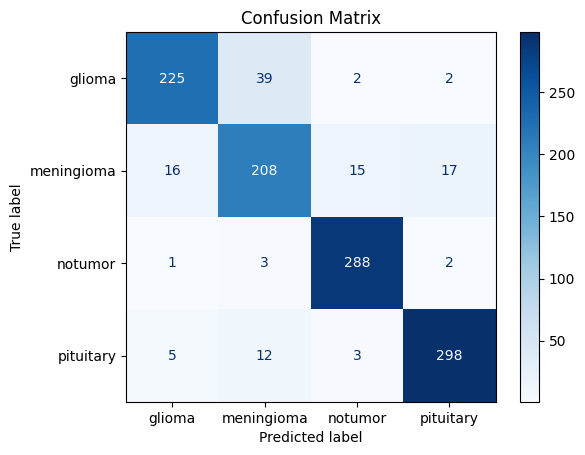

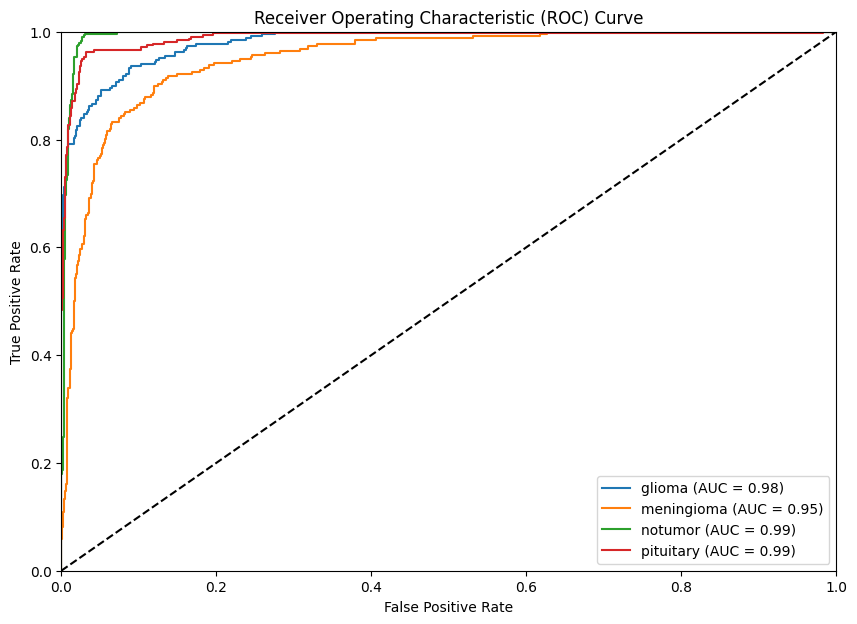

In [29]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming test_dataset is your TensorFlow dataset for testing
true_labels = []
predictions = []

# Get true labels and predictions
for x, y in test_dataset:
    true_labels.append(y.numpy())  # Append the true labels
    preds = model.predict(x)  # Get predictions from the model
    predictions.append(preds)

# Concatenate the true labels and predictions
true_labels_np = np.concatenate(true_labels)
predictions_np = np.concatenate(predictions)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions_np, axis=1)  # Get the index of the class with the highest probability
true_classes = np.argmax(true_labels_np, axis=1)  # Assuming one-hot encoding for labels

# If you have specific class labels, you can define them like this:
class_labels = ["glioma",	"meningioma",	"notumor",	"pituitary"]  # Change this to your actual class labels

# Calculate accuracy metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')  # Weighted average for multi-class
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Binarize the output for multi-class ROC
num_classes = len(class_labels)  # Get number of classes from your class labels
true_classes_bin = label_binarize(true_classes, classes=range(num_classes))
predictions_bin = predictions_np  # Model already gives probabilities

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()